## MNIST 손글씨 다중분류 - FCN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2023                
np.random.seed(seed)
tf.random.set_seed(seed)
import warnings
warnings.filterwarnings('ignore')

- 데이터 전처리

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape        # 28, 28 => 2차원, FCN은 2차원을 못받기에 -1을 써서 차원을 바꿔준다 (밑에 reshape 참조)

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

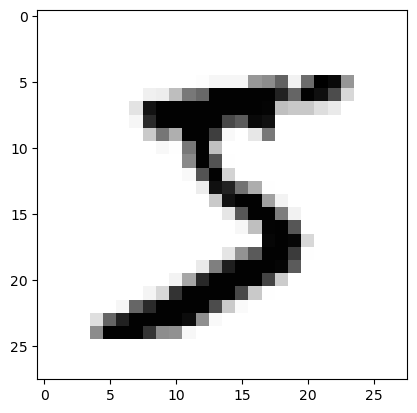

In [4]:
plt.imshow(X_train[0], cmap='Greys');

In [5]:
import sys
for row in X_train[0]:
    for x in row:
        sys.stdout.write(f'{x:3d} ')
    sys.stdout.write('\n')          # 0은 까만색, 숫자가 높을수록 밝은색 (ex: 255 제일 밝은 색)

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0 
  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0 
  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0 
  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0 

In [6]:
# X scaling
# 이미지 데이터는 0 ~ 1 사이의 값으로 스케일링
X_train = X_train / 255.
X_test = X_test / 255.

In [7]:
# Fully Connected Network(Dense layer)은 1차원 데이터만 처리 가능하므로 차원 축소
X_train = X_train.reshape(-1, 784)      # 784 = 28*28
X_test = X_test.reshape(-1, 784)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [8]:
# y 값읜 분포
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [9]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

- 모델 정의/설정/학습/평가

In [10]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
model = Sequential([
    Dense(1000, input_dim=784, activation='relu'),
    Dropout(0.25),      # 중간에 1/4 쉬게한다
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(48, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              785000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               256256    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 48)                12336     
                                                                 
 dense_3 (Dense)             (None, 10)                490       
                                                                 
Total params: 1054082 (4.02 MB)
Trainable params: 105408

In [12]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [14]:
mc = ModelCheckpoint('models/best_mnist.h5', verbose=1, save_best_only=True)
es = EarlyStopping(patience=5)
hist = model.fit(X_train, Y_train, validation_split=0.2, 
                 epochs=100, batch_size=256, verbose=1, 
                 callbacks=[mc, es])

Epoch 1/100
186/188 [============================>.] - ETA: 0s - loss: 0.3557 - accuracy: 0.8917
Epoch 1: val_loss improved from inf to 0.13011, saving model to models\best_mnist.h5
188/188 [==============================] - 6s 26ms/step - loss: 0.3546 - accuracy: 0.8920 - val_loss: 0.1301 - val_accuracy: 0.9613
Epoch 2/100
187/188 [============================>.] - ETA: 0s - loss: 0.1292 - accuracy: 0.9612
Epoch 2: val_loss improved from 0.13011 to 0.09153, saving model to models\best_mnist.h5
188/188 [==============================] - 5s 26ms/step - loss: 0.1292 - accuracy: 0.9612 - val_loss: 0.0915 - val_accuracy: 0.9707
Epoch 3/100
187/188 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9727
Epoch 3: val_loss improved from 0.09153 to 0.08314, saving model to models\best_mnist.h5
188/188 [==============================] - 5s 25ms/step - loss: 0.0884 - accuracy: 0.9727 - val_loss: 0.0831 - val_accuracy: 0.9744
Epoch 4/100
186/188 [============================>

In [15]:
best_model = load_model('models/best_mnist.h5')
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0627 - accuracy: 0.9808


[0.06272991001605988, 0.9807999730110168]

- 시각화

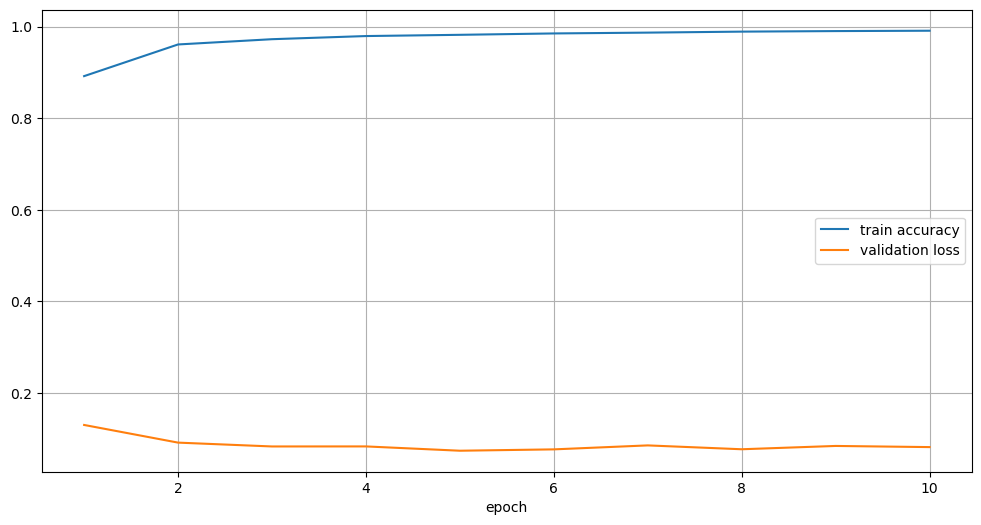

In [16]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

plt.figure(figsize=(12,6))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid(), plt.xlabel('epoch')
plt.show()

In [17]:
model2 = Sequential([
    Dense(1000, input_dim=784, activation='relu'),
    Dense(256, activation='relu'),
    Dense(48, activation='relu'),
    Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              785000    
                                                                 
 dense_5 (Dense)             (None, 256)               256256    
                                                                 
 dense_6 (Dense)             (None, 48)                12336     
                                                                 
 dense_7 (Dense)             (None, 10)                490       
                                                                 
Total params: 1054082 (4.02 MB)
Trainable params: 1054082 (4.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model2.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [19]:
mc2 = ModelCheckpoint('models/best_mnist.h5', verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=5)
hist2 = model2.fit(X_train, Y_train, validation_split=0.2, 
                 epochs=100, batch_size=256, verbose=1, 
                 callbacks=[mc2, es2])

Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.9104
Epoch 1: val_loss improved from inf to 0.13646, saving model to models\best_mnist.h5
188/188 [==============================] - 5s 24ms/step - loss: 0.3059 - accuracy: 0.9104 - val_loss: 0.1365 - val_accuracy: 0.9611
Epoch 2/100
187/188 [============================>.] - ETA: 0s - loss: 0.1021 - accuracy: 0.9697
Epoch 2: val_loss improved from 0.13646 to 0.08952, saving model to models\best_mnist.h5
188/188 [==============================] - 4s 23ms/step - loss: 0.1019 - accuracy: 0.9698 - val_loss: 0.0895 - val_accuracy: 0.9722
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9815
Epoch 3: val_loss improved from 0.08952 to 0.08268, saving model to models\best_mnist.h5
188/188 [==============================] - 4s 22ms/step - loss: 0.0607 - accuracy: 0.9815 - val_loss: 0.0827 - val_accuracy: 0.9742
Epoch 4/100
186/188 [============================>

In [21]:
best_model2 = load_model('models/best_mnist.h5')
best_model2.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0667 - accuracy: 0.9804


[0.06673404574394226, 0.980400025844574]

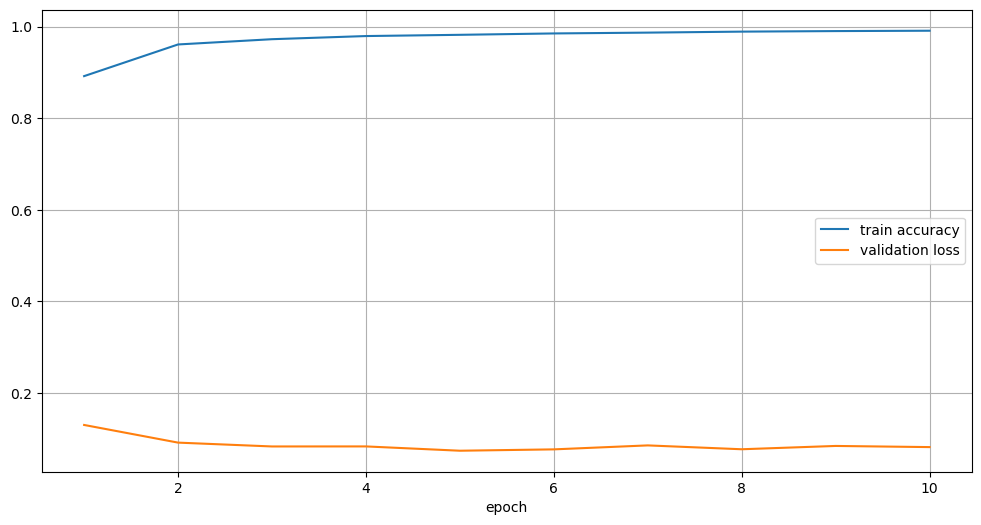

In [22]:
y_acc2 = hist.history['accuracy']
y_vloss2 = hist.history['val_loss']
xs = np.arange(1, len(y_acc2)+1)

plt.figure(figsize=(12,6))
plt.plot(xs, y_acc2, label='train accuracy')
plt.plot(xs, y_vloss2, label='validation loss')
plt.legend(), plt.grid(), plt.xlabel('epoch')
plt.show()